<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 

Author: Mariya Mansurova, Analyst & developer in Yandex.Metrics team. Translated by Ivan Zakharov, ML enthusiast. <br>This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center> Assignment #9 (demo)
## <center> Time series analysis

**Same assignment as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/a9-demo-time-series-analysis) + [solution](https://www.kaggle.com/kashnitsky/a9-demo-time-series-analysis-solution).**

**Fill cells marked with "Your code here" and submit your answers to the questions through the [web form](https://docs.google.com/forms/d/1UYQ_WYSpsV3VSlZAzhSN_YXmyjV7YlTP8EYMg8M8SoM/edit).**

In [195]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

print(__version__) # need 1.9.0 or greater
init_notebook_mode(connected = True)


def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

4.12.0


## Data preparation

In [196]:
df = pd.read_csv('../../data/wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [197]:
df.shape

(383, 7)

## Predicting with FB Prophet
We will train at first 5 months and predict the number of trips for June.

In [198]:
df.date = pd.to_datetime(df.date)

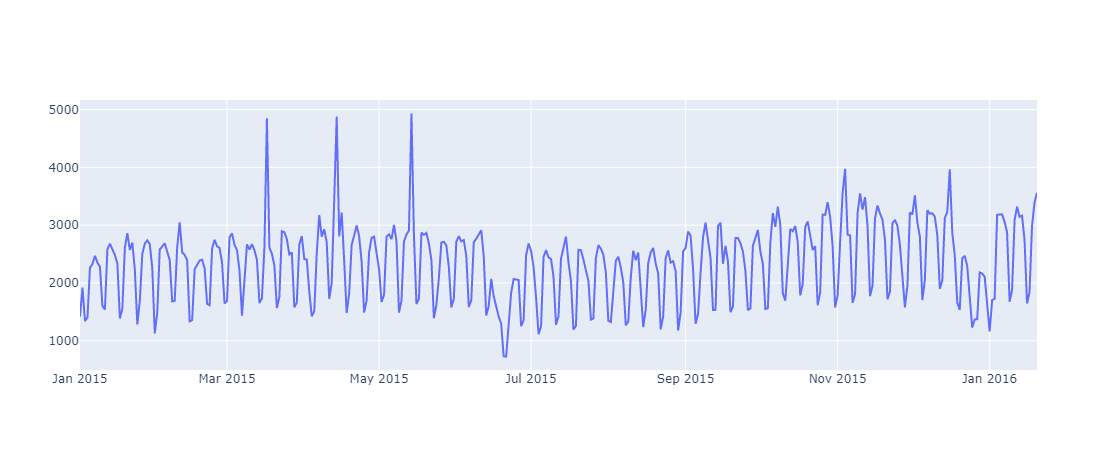

In [199]:
plotly_df(df.set_index('date')[['count']])

In [200]:
from fbprophet import Prophet

In [201]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
df.tail()

,ds,y
382,2016-01-16,1644
381,2016-01-17,1836
376,2016-01-18,2983
375,2016-01-19,3389
372,2016-01-20,3559


In [202]:
train_df = df[:-predictions].copy()
test_df = df[-predictions:].copy()

model = Prophet()
model.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [203]:
predictions = model.predict(test_df)
predictions.tail()[['ds', 'yhat']]

,ds,yhat
25,2016-01-16,2118.567791
26,2016-01-17,2264.969830
27,2016-01-18,3272.462326
28,2016-01-19,3537.990143
29,2016-01-20,3427.525825


**<font color='red'>Question 1:</font>** What is the prediction of the number of views of the wiki page on January 20? Round to the nearest integer.

- 4947
- <span style="background-color:yellow">3426</span>
- 5229
- 2744

Estimate the quality of the prediction with the last 30 points.

**<font color='red'>Question 2:</font> What is MAPE equal to?**

- <span style="background-color:yellow">34.5</span>
- 42.42
- 5.39
- 65.91

In [204]:
def mape(expected, predicted):
    errors = np.abs(predicted - expected)
    return (errors / expected).mean() * 100

mape(test_df['y'].values, predictions['yhat'].values)

34.539531179905794

**<font color='red'>Question 3:</font> What is MAE equal to?**

- 355
- 4007
- <span style="background-color:yellow">600</span>
- 903

In [205]:
def mae(expected, predicted):
    errors = np.abs(predicted - expected)
    return errors.mean()

mae(test_df['y'].values, predictions['yhat'].values)

600.6052411948428

## Predicting with ARIMA

In [206]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.tsa.api as smt

plt.rcParams['figure.figsize'] = (15, 10)

**<font color='red'>Question 4:</font> Let's verify the stationarity of the series using the Dickey-Fuller test. Is the series stationary? What is the p-value?**

- Series is stationary, p_value = 0.107
- <span style="background-color:yellow">Series is not stationary, p_value = 0.107</span>
- Series is stationary, p_value = 0.001
- Series is not stationary, p_value = 0.001

In [207]:
print('p-value:', sm.tsa.stattools.adfuller(train_df['y'])[1])

p-value: 0.10739219627612051


**Next, we turn to the construction of the SARIMAX model (`sm.tsa.statespace.SARIMAX`).<br> <font color='red'>Question 5:</font> What parameters are the best for the model according to the `AIC` criterion?**

- D = 1, d = 0, Q = 0, q = 2, P = 3, p = 1
- D = 2, d = 1, Q = 1, q = 2, P = 3, p = 1
- D = 1, d = 1, Q = 1, q = 2, P = 3, p = 1
- D = 0, d = 0, Q = 0, q = 2, P = 3, p = 1

In [208]:
data = train_df.copy()
data['y_box_cox'], lmbda = scs.boxcox(data['y'])
print('Optimal parameter for Box-Cox transformaion:', lmbda)
print('p-value:', sm.tsa.stattools.adfuller(data['y_box_cox'])[1])

Optimal parameter for Box-Cox transformaion: 0.7328410888410415
p-value: 0.11698088950892471


Dickey-Fuller test still doesn't disprove a hypothesis about series non-stacionarity. Let's take week seasonal diffreneces.

In [209]:
data['y_season'] = data['y_box_cox'] - data['y_box_cox'].shift(7)
print('p-value:', sm.tsa.stattools.adfuller(data['y_season'][7:])[1])

p-value: 4.839412375701255e-08


In [210]:
parameters_list = [
    (1, 0, 0, 2, 3, 1),
    (2, 1, 1, 2, 3, 1),
    (1, 1, 1, 2, 3, 1),
    (0, 0, 0, 2, 3, 1)]
# indexes
D, d, Q, q, P, p = list(range(6))

In [211]:
results = []
best_aic = float("inf")

for param in parameters_list:
    #try except for invalid parameters sets
    try:
        order = param[p], param[d], param[q]
        seasonal_order = param[P], param[D], param[Q], 7
        model=sm.tsa.statespace.SARIMAX(data['y_box_cox'],
                                        order=order, 
                                        seasonal_order=seasonal_order).fit(disp=-1)
    except ValueError:
        continue
    aic = model.aic
    # save best model aic and its parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [212]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
result_table.sort_values(by = 'aic', ascending=True, inplace=True)
result_table

,parameters,aic
1,"(2, 1, 1, 2, 3, 1)",3534.540192
0,"(1, 0, 0, 2, 3, 1)",3556.880030
2,"(1, 1, 1, 2, 3, 1)",3557.850675
3,"(0, 0, 0, 2, 3, 1)",3674.915908


In [213]:
# create SARIMAX model with best parameters set
best_params = result_table.iloc[0]['parameters']
order = best_params[p], best_params[d], best_params[q]
seasonal_order = best_params[P], best_params[D], best_params[Q], 7
best_model = sm.tsa.statespace.SARIMAX(data['y_box_cox'],
                                       order=order, 
                                       seasonal_order=seasonal_order).fit(disp=-1)
print(best_model.summary())
print('p-value:', sm.tsa.stattools.adfuller(best_model.resid[7:])[1])

                                      SARIMAX Results                                      
Dep. Variable:                           y_box_cox   No. Observations:                  353
Model:             SARIMAX(1, 1, 2)x(3, 2, [1], 7)   Log Likelihood               -1759.270
Date:                             Sun, 22 Nov 2020   AIC                           3534.540
Time:                                     14:05:46   BIC                           3565.125
Sample:                                          0   HQIC                          3546.729
                                             - 353                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4770      0.118      4.059      0.000       0.247       0.707
ma.L1         -0.9903      

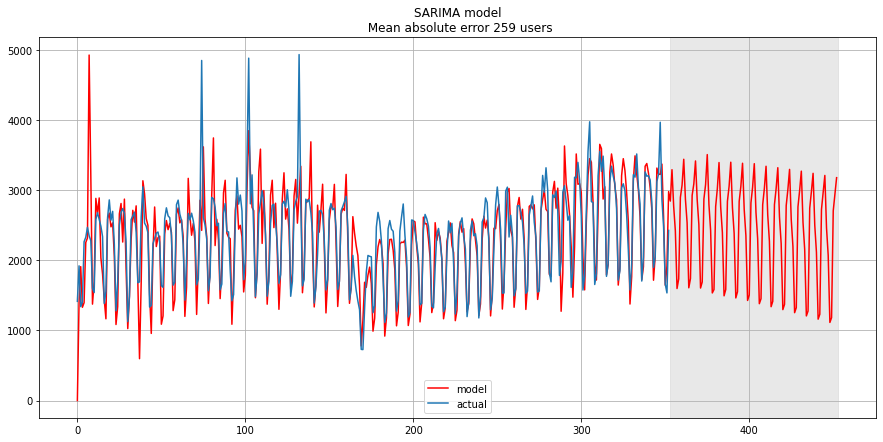

In [216]:
def invboxcox(y, lmbda):
    # reverse Box-Cox transformation
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y) / lmbda))


forecast_len = 100
data['arima_model'] = invboxcox(best_model.fittedvalues, lmbda)
forecast_box_cox = best_model.predict(start=data.shape[0],
                                      end=data.shape[0] + forecast_len - 1)
forecast = invboxcox(forecast_box_cox, lmbda)
forecast = data['arima_model'].append(forecast).values
actual = data['y'].values
views_mae = mae(actual, forecast[:-forecast_len])
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title(f'SARIMA model\n Mean absolute error {int(views_mae)} users')
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)